# Get predictions

In [52]:
# import jsonlines
import pandas as pd
import os

import sys
sys.path.append('../../../../chemprop')
sys.path.append('../../../../chemprop/chemprop')


# sys.path.append('../../../scripts/baselines/neuralfingerprints')

from chemprop.utils import load_checkpoint
import torch
from sklearn.metrics import r2_score

In [42]:
from tqdm import tqdm

In [26]:
from typing import Callable, List

In [2]:
from logging import Logger
import logging
import os
import sys
from typing import List

import numpy as np
from tensorboardX import SummaryWriter
import torch
from tqdm import trange
from torch.optim.lr_scheduler import ExponentialLR

# from evaluate import evaluate, evaluate_predictions
# from predict import predict
# from train import train
from chemprop.args import TrainArgs
from chemprop.data import get_class_sizes, get_data, MoleculeDataLoader, split_data, StandardScaler, validate_dataset_type
from chemprop.models import MoleculeModel
from chemprop.nn_utils import param_count
from chemprop.utils import build_optimizer, build_lr_scheduler, get_loss_func, get_metric_func, load_checkpoint,\
    makedirs, save_checkpoint, save_smiles_splits

In [3]:
from chemprop.args import TrainArgs

In [4]:
NUM_EXP = 4

In [5]:
class Args(object):
    def __init__(self, adict):
        self.__dict__.update(adict)

In [6]:
LOG_PATH = '../../../../chemprop/logs/exp_'+str(NUM_EXP)

In [7]:
SMILES_COLUMN = 'smiles'
VALUE_COLUMN = 'logP'
PREDS_COLUMN = 'logP_pred'

In [8]:
DATASET_OUTPUT_PATH = '../../../data/4_best_baselines_predictions/dmpnn'

In [9]:
MODEL_PATH = os.path.join(LOG_PATH,'fold_0/model_0')

In [10]:
model = load_checkpoint(os.path.join(MODEL_PATH, 'model.pt'), device=torch.device('cpu'))

Loading pretrained parameter "encoder.encoder.cached_zero_vector".
Loading pretrained parameter "encoder.encoder.W_i.weight".
Loading pretrained parameter "encoder.encoder.W_h.weight".
Loading pretrained parameter "encoder.encoder.W_o.weight".
Loading pretrained parameter "encoder.encoder.W_o.bias".
Loading pretrained parameter "ffn.1.weight".
Loading pretrained parameter "ffn.1.bias".
Loading pretrained parameter "ffn.4.weight".
Loading pretrained parameter "ffn.4.bias".


In [ ]:
def evaluate_predictions(preds: List[List[float]],
                         targets: List[List[float]],
                         num_tasks: int,
                         metric_func: Callable,
                         dataset_type: str,
                         logger: logging.Logger = None) -> List[float]:
    """
    Evaluates predictions using a metric function after filtering out invalid targets.

    :param preds: A list of lists of shape :code:`(data_size, num_tasks)` with model predictions.
    :param targets: A list of lists of shape :code:`(data_size, num_tasks)` with targets.
    :param num_tasks: Number of tasks.
    :param metric_func: Metric function which takes in a list of targets and a list of predictions.
    :param dataset_type: Dataset type.
    :param logger: A logger to record output.
    :return: A list with the score for each task based on :code:`metric_func`.
    """
    info = logger.info if logger is not None else print

    if len(preds) == 0:
        return [float('nan')] * num_tasks

    # Filter out empty targets
    # valid_preds and valid_targets have shape (num_tasks, data_size)
    valid_preds = [[] for _ in range(num_tasks)]
    valid_targets = [[] for _ in range(num_tasks)]
    for i in range(num_tasks):
        for j in range(len(preds)):
            if targets[j][i] is not None:  # Skip those without targets
                valid_preds[i].append(preds[j][i])
                valid_targets[i].append(targets[j][i])

    # Compute metric
    results = []
    results_r2 = []
    
    for i in range(num_tasks):
        # # Skip if all targets or preds are identical, otherwise we'll crash during classification
        if dataset_type == 'classification':
            nan = False
            if all(target == 0 for target in valid_targets[i]) or all(target == 1 for target in valid_targets[i]):
                nan = True
                info('Warning: Found a task with targets all 0s or all 1s')
            if all(pred == 0 for pred in valid_preds[i]) or all(pred == 1 for pred in valid_preds[i]):
                nan = True
                info('Warning: Found a task with predictions all 0s or all 1s')

            if nan:
                results.append(float('nan'))
                continue

        if len(valid_targets[i]) == 0:
            continue

        if dataset_type == 'multiclass':
            results.append(metric_func(valid_targets[i], valid_preds[i], labels=list(range(len(valid_preds[i][0])))))
        else:
            results.append(metric_func(valid_targets[i], valid_preds[i]))
            results_r2.append(r2_score(valid_targets[i], valid_preds[i]))

    return results, results_r2

In [ ]:
def evaluate(model: MoleculeModel,
             data_loader: MoleculeDataLoader,
             num_tasks: int,
             metric_func: Callable,
             dataset_type: str,
             scaler: StandardScaler = None,
             logger: logging.Logger = None) -> List[float]:
    """
    Evaluates an ensemble of models on a dataset by making predictions and then evaluating the predictions.

    :param model: A :class:`~chemprop.models.model.MoleculeModel`.
    :param data_loader: A :class:`~chemprop.data.data.MoleculeDataLoader`.
    :param num_tasks: Number of tasks.
    :param metric_func: Metric function which takes in a list of targets and a list of predictions.
    :param dataset_type: Dataset type.
    :param scaler: A :class:`~chemprop.features.scaler.StandardScaler` object fit on the training targets.
    :param logger: A logger to record output.
    :return: A list with the score for each task based on :code:`metric_func`.
    """
    preds = predict(
        model=model,
        data_loader=data_loader,
        scaler=scaler
    )

    targets = data_loader.targets()

    results, results_r2 = evaluate_predictions(
        preds=preds,
        targets=targets,
        num_tasks=num_tasks,
        metric_func=metric_func,
        dataset_type=dataset_type,
        logger=logger
    )

    return results, results_r2

In [ ]:
def predict(model: MoleculeModel,
            data_loader: MoleculeDataLoader,
            disable_progress_bar: bool = False,
            scaler: StandardScaler = None) -> List[List[float]]:
    """
    Makes predictions on a dataset using an ensemble of models.

    :param model: A :class:`~chemprop.models.model.MoleculeModel`.
    :param data_loader: A :class:`~chemprop.data.data.MoleculeDataLoader`.
    :param disable_progress_bar: Whether to disable the progress bar.
    :param scaler: A :class:`~chemprop.features.scaler.StandardScaler` object fit on the training targets.
    :return: A list of lists of predictions. The outer list is molecules while the inner list is tasks.
    """
    model.eval()

    preds = []

    for batch in tqdm(data_loader, disable=disable_progress_bar):
        # Prepare batch
        batch: MoleculeDataset
        mol_batch, features_batch = batch.batch_graph(), batch.features()

        # Make predictions
        with torch.no_grad():
            batch_preds = model(mol_batch, features_batch)

        batch_preds = batch_preds.data.cpu().numpy()

        # Inverse scale if regression
        if scaler is not None:
            batch_preds = scaler.inverse_transform(batch_preds)

        # Collect vectors
        batch_preds = batch_preds.tolist()
        preds.extend(batch_preds)

    return preds


In [12]:
args = TrainArgs()
args.load(os.path.join(LOG_PATH,'fold_0', 'args.json'),skip_unsettable = True)

TrainArgs(prog='ipykernel_launcher.py', usage=None, description=None, formatter_class=<class 'argparse.HelpFormatter'>, conflict_handler='error', add_help=True)

In [13]:
args.data_path = '../../../data/raw/baselines/dmpnn/logp_wo_averaging_train.csv'

In [14]:
args.separate_test_path = '../../../data/raw/baselines/dmpnn/logp_wo_averaging_test.csv'

In [15]:
args.separate_val_path = '../../../data/raw/baselines/dmpnn/logp_wo_averaging_validation.csv'

In [16]:
if args.separate_test_path:
    test_data = get_data(path=args.separate_test_path, args=args, features_path=args.separate_test_features_path)

2067it [00:00, 121901.38it/s]
100%|██████████| 2067/2067 [00:00<00:00, 176916.71it/s]


In [18]:
test_data[0]

In [21]:
if args.features_scaling:
    features_scaler = train_data.normalize_features(replace_nan_token=0)
    val_data.normalize_features(features_scaler)
    test_data.normalize_features(features_scaler)
else:
    features_scaler = None

In [22]:
test_smiles, test_targets = test_data.smiles(), test_data.targets()

In [32]:
cache = False
num_workers = args.num_workers

In [33]:
test_data_loader = MoleculeDataLoader(
    dataset=test_data,
    batch_size=args.batch_size,
    num_workers=num_workers,
    cache=cache
)

In [34]:
loss_func = get_loss_func(args)
metric_func = get_metric_func(metric=args.metric)

In [38]:
train_data = pd.read_csv(args.data_path)

In [40]:
scaler = StandardScaler().fit(train_data['logP'])

In [53]:
test_preds = predict(
            model=model,
            data_loader=test_data_loader,
            scaler=scaler
        )
test_scores, test_r2 = evaluate_predictions(
    preds=test_preds,
    targets=test_targets,
    num_tasks=args.num_tasks,
    metric_func=metric_func,
    dataset_type=args.dataset_type,
)


100%|██████████| 42/42 [00:07<00:00,  5.70it/s]


In [45]:
ERROR_COLUMN = 'Absolute Error'
SMILES_COLUMN = 'smiles'
VALUE_COLUMN = 'logP'
PREDS_COLUMN = 'logP_pred'

In [116]:
test_predictions = pd.DataFrame(columns=[SMILES_COLUMN,VALUE_COLUMN,PREDS_COLUMN])

In [117]:
test_predictions[SMILES_COLUMN] = test_smiles

In [118]:
test_predictions[VALUE_COLUMN] = np.array(test_targets, dtype=float).reshape(-1)

In [119]:
test_predictions[PREDS_COLUMN] = np.array(test_preds, dtype=float).reshape(-1)

In [120]:
DATASET_OUTPUT_PATH = '../../../data/4_best_baselines_predictions/dmpnn'

In [121]:
test_predictions.to_csv(os.path.join(DATASET_OUTPUT_PATH, 'logp_wo_averaging_test_preds.csv'), index = False)

In [55]:
test_scores, test_r2

([0.44085248822198], [0.9422875741025669])

# Get worst/best molecules

In [10]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
import matplotlib.pyplot as plt
import os
import numpy as np

In [11]:
ERROR_COLUMN = 'Absolute Error'
SMILES_COLUMN = 'smiles'
VALUE_COLUMN = 'logP'
PREDS_COLUMN = 'logP_pred'

DATASET_INPUT_PATH = '../../../data/raw/baselines/dmpnn/logs/exp_351/folds/fold_0'

DATASET_OUTPUT_PATH = '../../../data/raw/baselines/dmpnn'

In [12]:
test_predictions = pd.read_csv(os.path.join(DATASET_INPUT_PATH, 'test_predictions.csv'))

In [13]:
test_predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2067 entries, 0 to 2066
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   smiles     2067 non-null   object 
 1   logP       2067 non-null   float64
 2   logP_pred  2067 non-null   float64
dtypes: float64(2), object(1)
memory usage: 48.6+ KB


In [14]:
test_predictions[ERROR_COLUMN] = np.abs(test_predictions[VALUE_COLUMN]-test_predictions[PREDS_COLUMN])

In [16]:
from sklearn.metrics import mean_squared_error, r2_score

In [28]:
print('Number of hydrophilic molecules = ', \
      len(test_predictions[test_predictions[VALUE_COLUMN]<0]))
print('Number of lipophilic molecules = ', \
      len(test_predictions[test_predictions[VALUE_COLUMN]>0]))

print('RMSE of hydrophilic molecules = ', \
      round(mean_squared_error(test_predictions[test_predictions[VALUE_COLUMN]<0][VALUE_COLUMN], \
                        test_predictions[test_predictions[VALUE_COLUMN]<0][PREDS_COLUMN], squared=False), 3))
print('RMSE of lipophilic molecules = ', \
      round(mean_squared_error(test_predictions[test_predictions[VALUE_COLUMN]>0][VALUE_COLUMN], \
                        test_predictions[test_predictions[VALUE_COLUMN]>0][PREDS_COLUMN], squared=False), 3))

print('R2 of hydrophilic molecules = ', \
      round(r2_score(test_predictions[test_predictions[VALUE_COLUMN]<0][VALUE_COLUMN], \
                        test_predictions[test_predictions[VALUE_COLUMN]<0][PREDS_COLUMN]), 3))
print('R2 of lipophilic molecules = ', \
      round(r2_score(test_predictions[test_predictions[VALUE_COLUMN]>0][VALUE_COLUMN], \
                        test_predictions[test_predictions[VALUE_COLUMN]>0][PREDS_COLUMN]), 3))

Number of hydrophilic molecules =  219
Number of lipophilic molecules =  1848
RMSE of hydrophilic molecules =  0.533
RMSE of lipophilic molecules =  0.429
R2 of hydrophilic molecules =  0.512
R2 of lipophilic molecules =  0.926


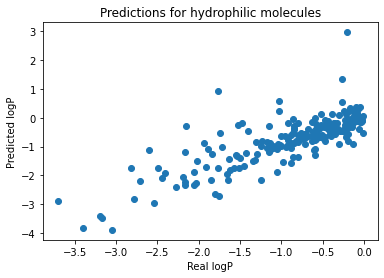

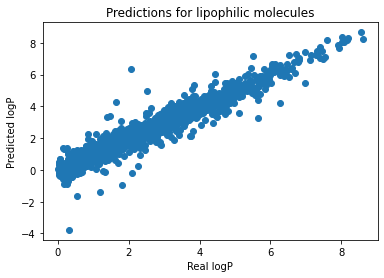

In [34]:
plt.scatter(test_predictions[test_predictions[VALUE_COLUMN]<0][VALUE_COLUMN], test_predictions[test_predictions[VALUE_COLUMN]<0][PREDS_COLUMN])
_ = plt.title('Predictions for hydrophilic molecules')
_ = plt.xlabel('Real logP')
_ = plt.ylabel('Predicted logP')
plt.show()
plt.scatter(test_predictions[test_predictions[VALUE_COLUMN]>0][VALUE_COLUMN], test_predictions[test_predictions[VALUE_COLUMN]>0][PREDS_COLUMN])
_ = plt.title('Predictions for lipophilic molecules')
_ = plt.xlabel('Real logP')
_ = plt.ylabel('Predicted logP')

In [23]:
test_predictions = test_predictions.sort_values(by=ERROR_COLUMN)

In [36]:
test_predictions.iloc[-100:-80]

,smiles,logP,logP_pred,Absolute Error
929,CCCCCCCCN=C(N)NNC(=O)Nc1ccc(Cl)cc1,4.35,3.501948,0.848052
1233,O=NN(CC(F)(F)F)CC(F)(F)F,2.15,1.298111,0.851889
1888,NC(=O)NN=CCCc1ccccc1,2.32,1.464930,0.855070
1816,O=NN(CCCl)C(=O)NC1(C(=O)O)CCCC1,2.01,1.153695,0.856305
2052,CC1CCC(C(C)C)CC1,5.56,4.699047,0.860953
1159,CCOc1ccc(NC(=O)CN(C)C(=O)c2ccc(C)o2)cc1OCC,2.09,2.951066,0.861066
286,CC(C)CC(N)C(=O)NC(Cc1ccccc1)C(=O)O,-1.15,-0.286958,0.863042
646,CCn1cc(C(=O)NC(C)C(=O)OC)c(=O)c2ccc(C)nc21,2.47,1.595681,0.874319
1764,CSC(C)=NOC(=O)N(C)SN(C)C(=O)c1cccc(C(F)(F)F)c1,2.50,3.376234,0.876234
1546,CCCCCCCCCCO,4.57,3.690457,0.879543


In [130]:
test_predictions.to_csv(os.path.join(DATASET_OUTPUT_PATH,'predictions_table.csv'), index = False)

## Draw best molecules

In [131]:
import os
import numpy as np
import pandas as pd

In [185]:
ERROR_COLUMN = 'Absolute Error'
SMILES_COLUMN = 'smiles'
VALUE_COLUMN = 'logP'
PREDS_COLUMN = 'logP_pred'

DATA_PATH = '../../../data/raw/baselines/dmpnn'

In [186]:
test_predictions = pd.read_csv(os.path.join(DATA_PATH,'predictions_table.csv'))

In [187]:
sorted_smiles = test_predictions[SMILES_COLUMN].values

In [188]:
NUMBER_OF_BEST = 100
NUMBER_OF_WORST = 100

In [189]:
best_pred_smiles = sorted_smiles[:NUMBER_OF_BEST]
worst_pred_smiles = sorted_smiles[-NUMBER_OF_WORST:]

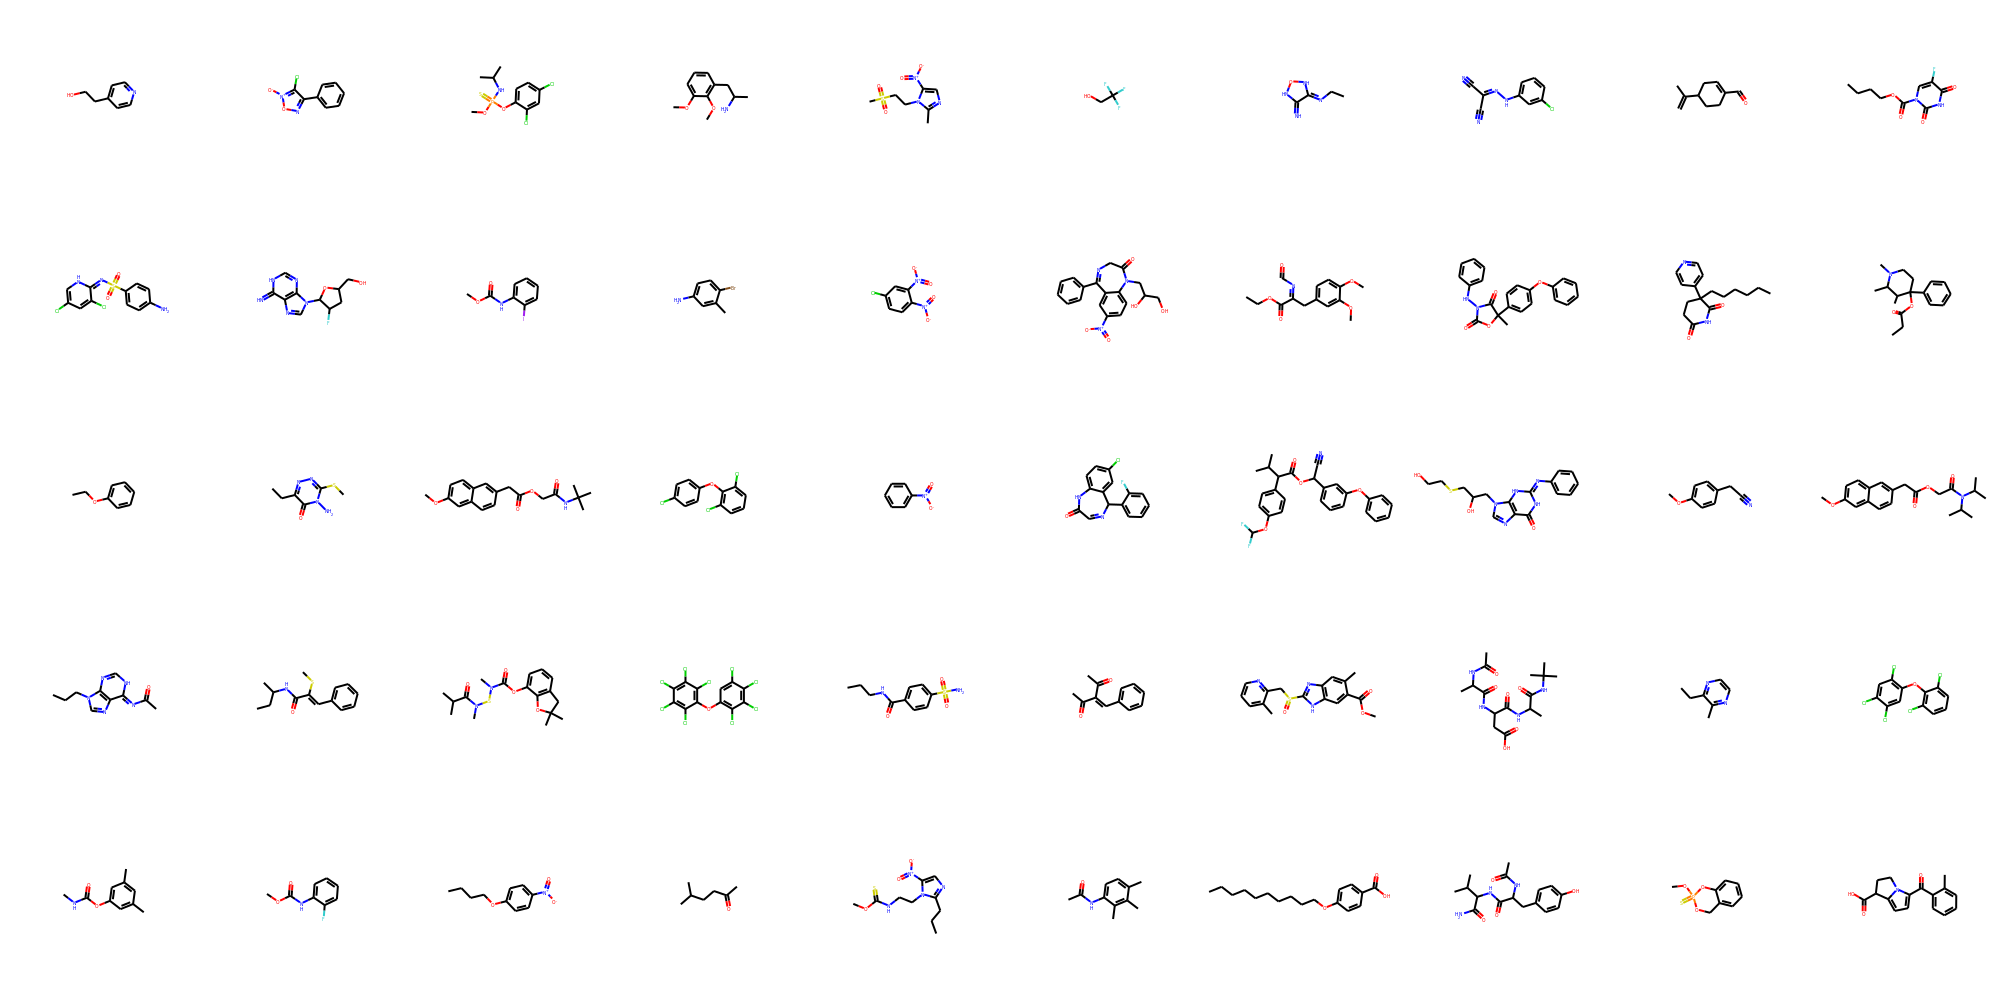

In [192]:
ms = [Chem.MolFromSmiles(smiles) for smiles in best_pred_smiles]
img=Draw.MolsToGridImage(ms,molsPerRow=10,subImgSize=(200,200))#,legends=[smiles for smiles in best_pred_smiles])    
img.save('../../../../DMPNN_best_preds_lq.png')
img

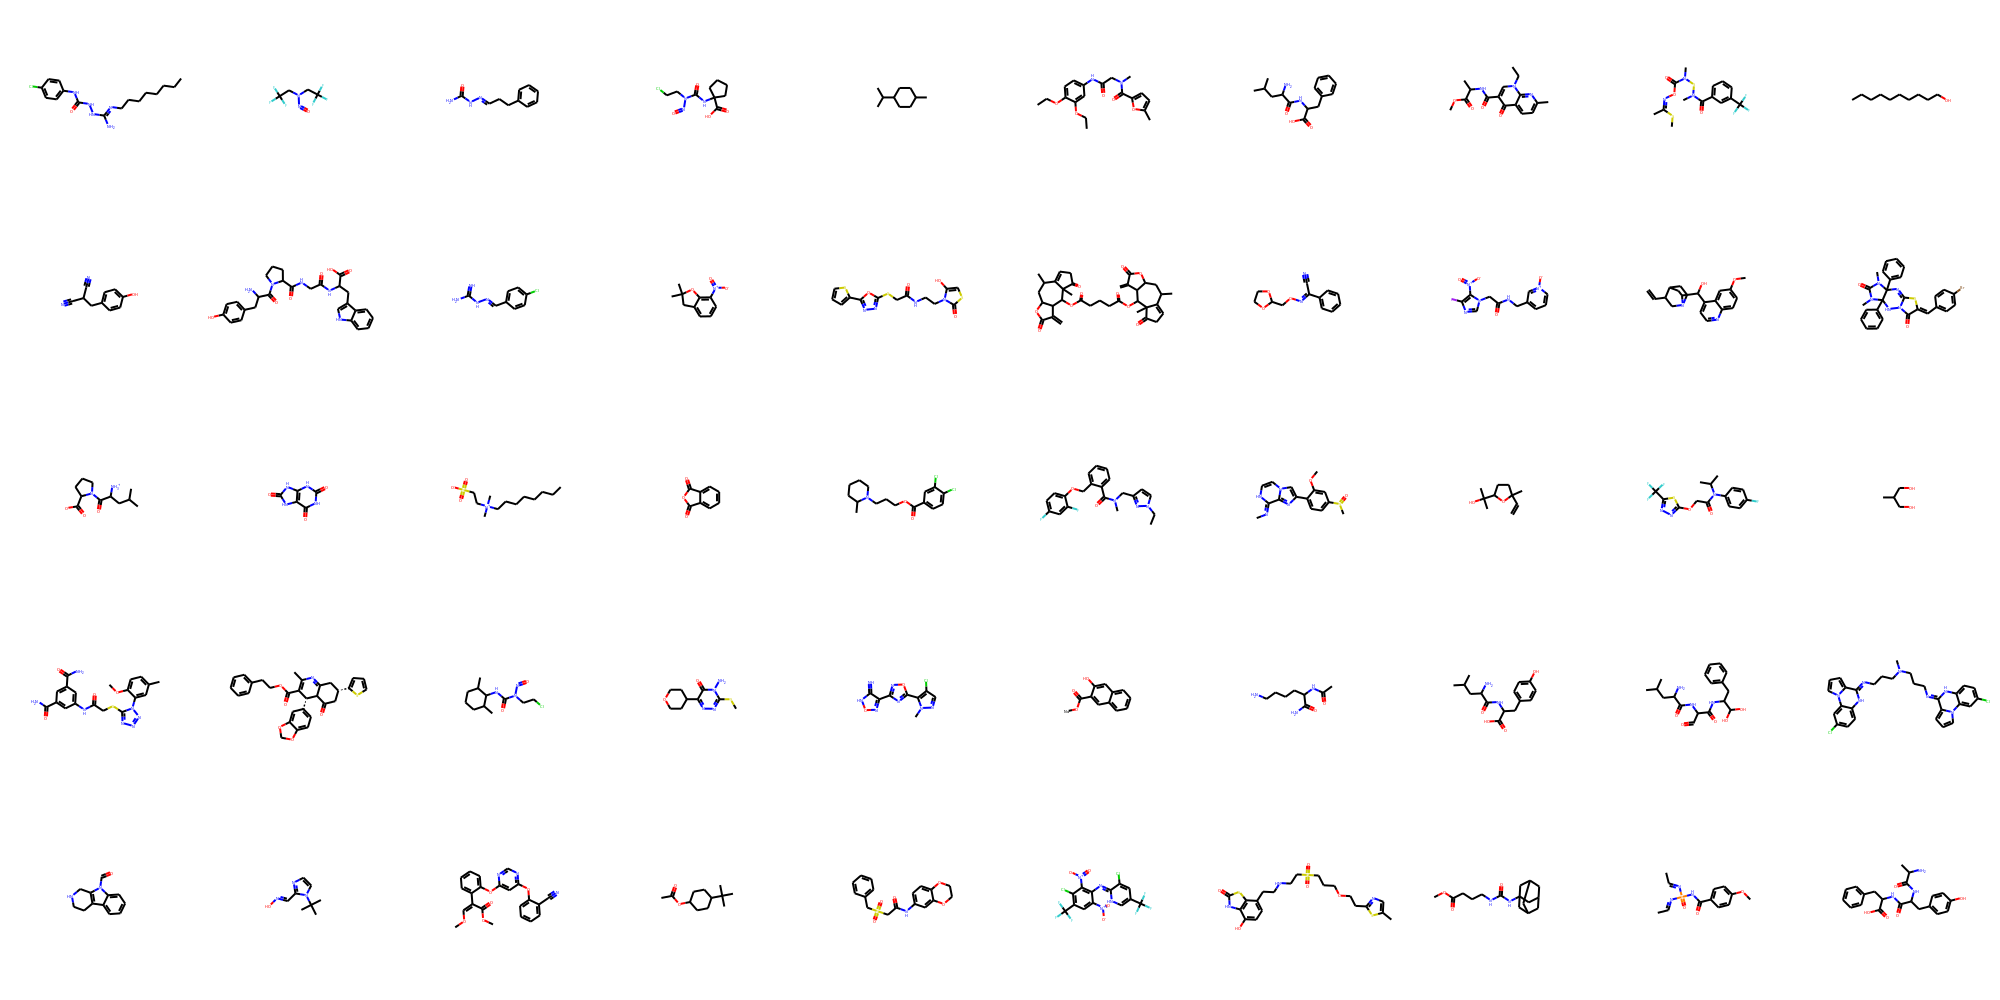

In [193]:
ms = [Chem.MolFromSmiles(smiles) for smiles in worst_pred_smiles]
img=Draw.MolsToGridImage(ms,molsPerRow=10,subImgSize=(200,200))#,legends=[smiles for smiles in worst_pred_smiles])    
img.save('../../../../DMPNN_worst_preds_lq.png')
img

### Get statistics

In [194]:
from scipy import stats
import seaborn as sns

In [195]:
def create_statistics(vals):
    values = vals.copy()
    mols = [Chem.MolFromSmiles(x) for x in values.smiles]
    
    atom_count = [mol.GetNumAtoms() for mol in mols]
    values['atom_count'] = pd.Series(atom_count)
    
    values['ring_count'] = pd.Series([mol.GetRingInfo().NumRings() for mol in mols])
    
    mol_atoms = [mol.GetAtoms() for mol in mols]
    non_simple_atom_count = [sum((num.GetAtomicNum() not in [1, 6, 8, 7]) for num in m_atoms) for m_atoms in mol_atoms]
    values['non_organogens_count'] = pd.Series(non_simple_atom_count)
    
    values['non_organogens_percent'] = values.non_organogens_count / values.atom_count *100
    
    benzene_smiles = 'C1=CC=CC=C1'
    pattern = Chem.MolFromSmiles(benzene_smiles)
    values['aromatic_count'] = pd.Series([len(mol.GetSubstructMatches(pattern)) for mol in mols])
    
    values['aromatic_rings_percent'] = values.aromatic_count / values.ring_count *100
    values['aromatic_rings_percent'] = values['aromatic_rings_percent'].fillna(0)
    
    values['bond_count'] =  [len(mol.GetBonds()) for mol in mols]
    values['aromatic_bond_count'] = [sum(bond.GetIsAromatic() for bond in mol.GetBonds()) for mol in mols]
    values['aromatic_bond_percent'] = values.aromatic_bond_count / values.bond_count * 100
    
    values_list = [pd.Series(Chem.CanonicalRankAtoms(mol, breakTies=False)).value_counts() for mol in mols]
    values['is_symmetric'] =  [len(values) == len(values[values % 2 == 0]) for values in values_list]
    
    return values

In [196]:
compare_data_with_stats = create_statistics(test_predictions)

In [197]:
compare_data_with_stats

,smiles,logP,logP_pred,Absolute Error,atom_count,ring_count,non_organogens_count,non_organogens_percent,aromatic_count,aromatic_rings_percent,bond_count,aromatic_bond_count,aromatic_bond_percent,is_symmetric
0,OCCc1ccncc1,0.10,0.100122,0.000122,9,1,0,0.000000,0,0.000000,9,6,66.666667,False
1,[O-][n+]1onc(-c2ccccc2)c1Cl,2.70,2.699795,0.000205,13,2,1,7.692308,1,50.000000,14,11,78.571429,False
2,COP(=S)(NC(C)C)Oc1ccc(Cl)cc1Cl,4.30,4.299360,0.000640,17,1,4,23.529412,1,100.000000,17,6,35.294118,False
3,COc1cccc(CC(C)N)c1OC,1.49,1.489322,0.000678,14,1,0,0.000000,1,100.000000,14,6,42.857143,False
4,Cc1ncc([N+](=O)[O-])n1CCS(C)(=O)=O,-0.82,-0.820723,0.000723,15,1,1,6.666667,0,0.000000,15,5,33.333333,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2062,CC1OC(OC2C(O)CC(OC3C(O)CC(OC4CCC5(C)C(CCC6C5CC...,-1.77,0.926779,2.696779,66,9,0,0.000000,0,0.000000,74,5,6.756757,False
2063,O=S(=O)(O[Na])c1cc(-n2nc3ccc4ccccc4c3n2)ccc1C=...,1.80,-0.945304,2.745304,32,5,2,6.250000,4,80.000000,36,27,75.000000,False
2064,N=C1C=CC(=C(c2ccc(N)cc2)c2ccc(N)cc2)C=C1,-0.21,2.959373,3.169373,22,3,0,0.000000,2,66.666667,24,12,50.000000,False
2065,O=C(O[K])C1C2CCC(O2)C1C(=O)O[K],0.32,-3.775163,4.095163,15,2,2,13.333333,0,0.000000,16,0,0.000000,False


In [198]:
best, middle, worst = np.array_split(compare_data_with_stats, 3)
middle = middle.reset_index()
worst = worst.reset_index()

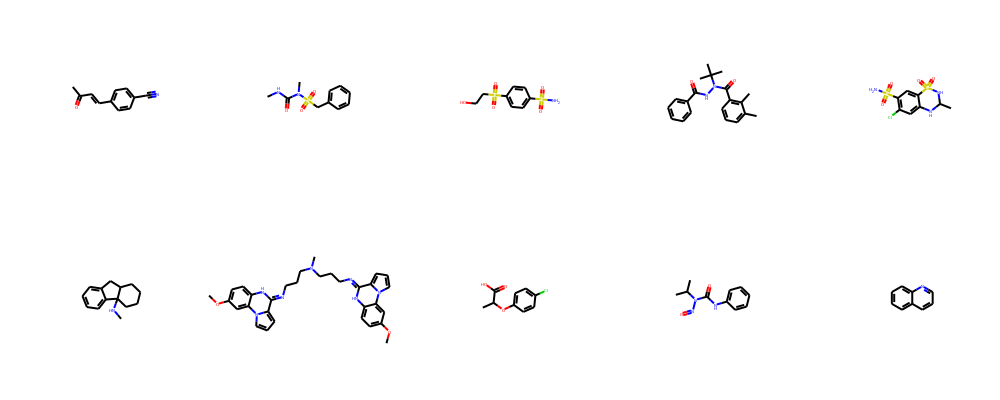

In [199]:
# Look through random 10 molecules from "best part"
ms = [Chem.MolFromSmiles(smiles) for smiles in best.sample(10).smiles]
img=Draw.MolsToGridImage(ms,molsPerRow=5,subImgSize=(200,200))#,legends=[smiles for smiles in worst_pred_smiles])    
img


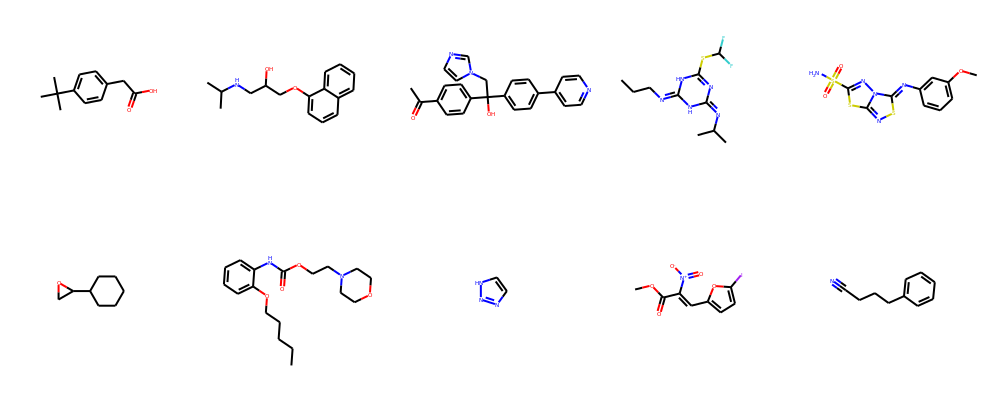

In [200]:
# Look through random 10 molecules from "middle part"
ms = [Chem.MolFromSmiles(smiles) for smiles in middle.sample(10).smiles]
img=Draw.MolsToGridImage(ms,molsPerRow=5,subImgSize=(200,200))#,legends=[smiles for smiles in worst_pred_smiles])    
img

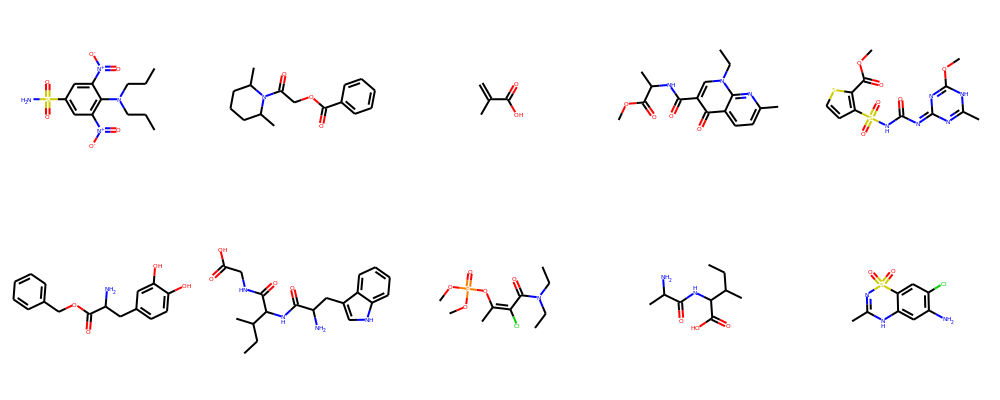

In [201]:
# Look through random 10 molecules from "worst part"
ms = [Chem.MolFromSmiles(smiles) for smiles in worst.sample(10).smiles]
img=Draw.MolsToGridImage(ms,molsPerRow=5,subImgSize=(200,200))#,legends=[smiles for smiles in worst_pred_smiles])    
img

In [202]:
NUMBER_OF_BEST = 200
NUMBER_OF_WORST = 200

In [203]:
best_n_vals = compare_data_with_stats.iloc[:NUMBER_OF_BEST]

In [204]:
worst_n_vals = compare_data_with_stats.iloc[-NUMBER_OF_WORST:].sort_values(by=ERROR_COLUMN, ascending = False)

### Check atom_count influence

In [205]:
print(stats.kruskal(best_n_vals.atom_count, worst_n_vals.atom_count))

KruskalResult(statistic=50.60539902042367, pvalue=1.129339403674052e-12)


<AxesSubplot:xlabel='atom_count'>

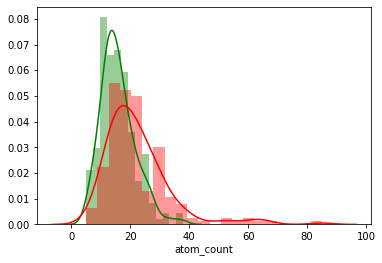

In [206]:
sns.distplot(best_n_vals.atom_count, color='g')
sns.distplot(worst_n_vals.atom_count, color='r')

### Check ring_count influence

In [207]:
print(stats.kruskal(best_n_vals.ring_count, worst_n_vals.ring_count))

KruskalResult(statistic=12.856844660193993, pvalue=0.00033624708229473496)


<AxesSubplot:xlabel='ring_count'>

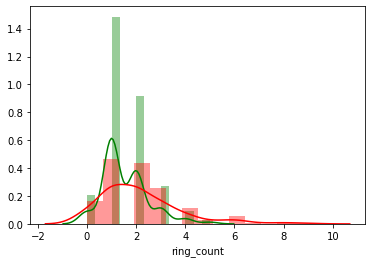

In [208]:
sns.distplot(best_n_vals.ring_count, color='g')
sns.distplot(worst_n_vals.ring_count, color='r')

### Check non_organogens_count influence

In [209]:
print(stats.kruskal(best_n_vals.non_organogens_count, worst_n_vals.non_organogens_count))

KruskalResult(statistic=1.3607231124058683, pvalue=0.24341219922154828)


<AxesSubplot:xlabel='non_organogens_count'>

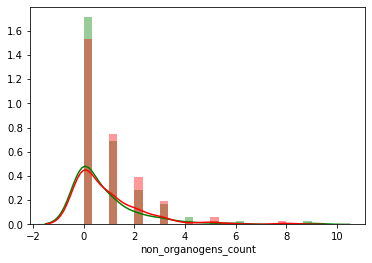

In [210]:
sns.distplot(best_n_vals.non_organogens_count, color='g')
sns.distplot(worst_n_vals.non_organogens_count, color='r')

### Check non_organogens_percent influence

In [211]:
print(stats.ttest_ind(best_n_vals.non_organogens_percent, worst_n_vals.non_organogens_percent))

Ttest_indResult(statistic=0.91045998752319, pvalue=0.36313103592190654)


<AxesSubplot:xlabel='non_organogens_percent'>

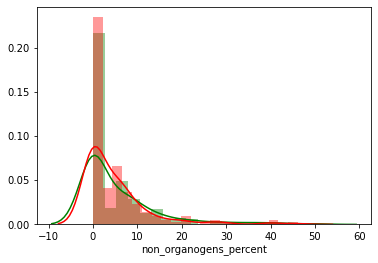

In [212]:
sns.distplot(best_n_vals.non_organogens_percent, color='g')
sns.distplot(worst_n_vals.non_organogens_percent, color='r')

### Check aromatic_count influence

In [213]:
print(stats.kruskal(best_n_vals.aromatic_count, worst_n_vals.aromatic_count))

KruskalResult(statistic=0.7510678458473034, pvalue=0.3861383549288592)


<AxesSubplot:xlabel='aromatic_count'>

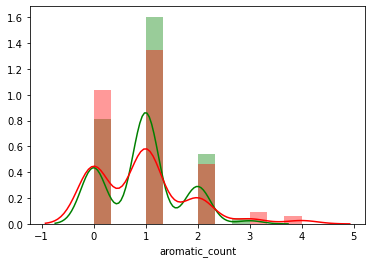

In [214]:
sns.distplot(best_n_vals.aromatic_count, color='g')
sns.distplot(worst_n_vals.aromatic_count, color='r')

### Check aromatic_rings_percent influence

In [215]:
print(stats.kruskal(best_n_vals.aromatic_rings_percent, worst_n_vals.aromatic_rings_percent))

KruskalResult(statistic=16.03268094368409, pvalue=6.225849596151651e-05)


<AxesSubplot:xlabel='aromatic_rings_percent'>

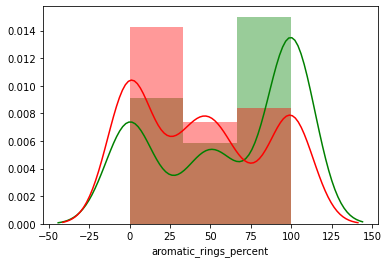

In [216]:
sns.distplot(best_n_vals.aromatic_rings_percent, color='g')
sns.distplot(worst_n_vals.aromatic_rings_percent, color='r')

### Check aromatic bond percent

In [217]:
print(stats.kruskal(best_n_vals.aromatic_bond_percent, worst_n_vals.aromatic_bond_percent))

KruskalResult(statistic=21.537314181354503, pvalue=3.4701051685614547e-06)


<AxesSubplot:xlabel='aromatic_bond_percent'>

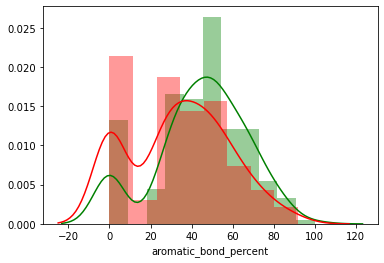

In [218]:
sns.distplot(best_n_vals.aromatic_bond_percent, color='g')
sns.distplot(worst_n_vals.aromatic_bond_percent, color='r')

### Check aromatic bond count

In [219]:
print(stats.kruskal(best_n_vals.aromatic_bond_count, worst_n_vals.aromatic_bond_count))

KruskalResult(statistic=0.24278454096355018, pvalue=0.6222021666954054)


<AxesSubplot:xlabel='aromatic_bond_count'>

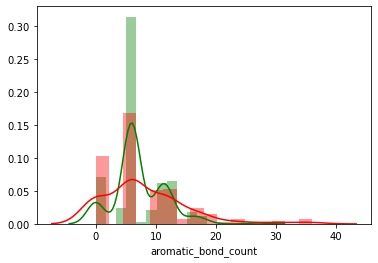

In [220]:
sns.distplot(best_n_vals.aromatic_bond_count, color='g')
sns.distplot(worst_n_vals.aromatic_bond_count, color='r')


### Symmetry analysis

In [226]:
symmetric_rull = lambda values: (len(values) - 1 <= len(values[values % 2 == 0])) or (len(values) - 1 <= len(values[(values % 2 == 1) & (values > 1)]))

In [228]:
values_list = [pd.Series(Chem.CanonicalRankAtoms(Chem.MolFromSmiles(smiles), breakTies=False)).value_counts() for smiles in compare_data_with_stats[SMILES_COLUMN]]
symmetric_indices = [symmetric_rull(values) for values in values_list]
not_symmetric_indices = [not e for e in symmetric_indices]

In [229]:
symmetric_y_predicted = compare_data_with_stats[PREDS_COLUMN][symmetric_indices]

In [231]:
symmetric_y_expected = compare_data_with_stats[VALUE_COLUMN][symmetric_indices]

In [232]:
not_symmetric_y_predicted = compare_data_with_stats[PREDS_COLUMN][not_symmetric_indices]

In [233]:
not_symmetric_y_expected = compare_data_with_stats[VALUE_COLUMN][not_symmetric_indices]

In [221]:
from sklearn.metrics import mean_squared_error

In [234]:
print("Test symmetric RMSE =", mean_squared_error(symmetric_y_expected, symmetric_y_predicted, squared=False))
print("Test symmetric R2-score is {0}".format(r2_score(symmetric_y_expected, symmetric_y_predicted)))

Test symmetric RMSE = 0.7664073064955049
Test symmetric R2-score is 0.8891239875706615


In [235]:
print("Test not symmetric RMSE =", mean_squared_error(not_symmetric_y_expected, not_symmetric_y_predicted, squared=False))
print("Test not symmetric R2-score is {0}".format(r2_score(not_symmetric_y_expected, not_symmetric_y_predicted)))

Test not symmetric RMSE = 0.42470038526469506
Test not symmetric R2-score is 0.9448009547313081
